# Tourist Visitors Time Series Forecasting

Anggota Kelompok:
- Muhammad Karov Ardava Barus (103052300001)
- Muhammad Alfayyedh Denof (XXXXXXXXX)
- Stephanie Maria Sianturi (XXXXXXXXX)

## Import Library & Tools

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Data Setup

In [30]:
DATA_PATH = 'https://raw.githubusercontent.com/Ardavaa/time-series-tourist-visitors/refs/heads/main/data/data.csv'
df = pd.read_csv(DATA_PATH)

df

,Date,TouristNumber
0,33604,8414
1,33635,9767
2,33664,13805
3,33695,12987
4,33725,32190
...,...,...
283,42217,82593
284,42248,53472
285,42278,30361
286,42309,25436


In [31]:
df['Date'] = pd.date_range(start="2000-01-01", periods=len(df), freq="ME")

Cek apakah ada data missing & duplikat

In [32]:
print(f'Jumlah data missing: {df.isna().sum().sum()}')
print(f'Jumlah data duplikat: {df.duplicated().sum()}')

Jumlah data missing: 0
Jumlah data duplikat: 0


Tidak ditemukan data missing & duplikat, maka dari itu kita tidak perlu menghandle case missing / duplicate values.

Cek kestasioneran data

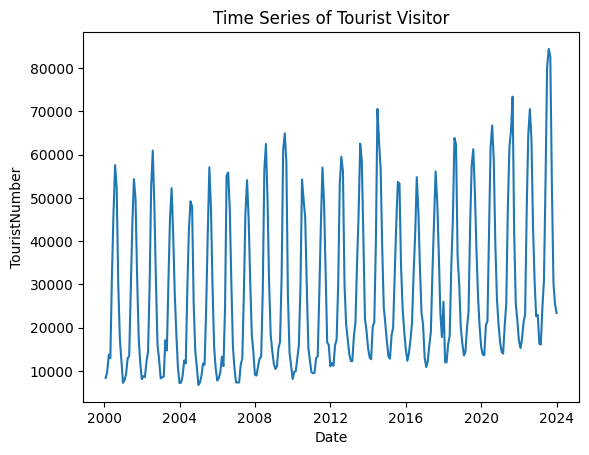

In [33]:
sns.lineplot(data=df, x='Date', y='TouristNumber')
plt.title('Time Series of Tourist Visitor')
plt.show()

Data yang di plot tidak stasioner. maka dari itu kita akan coba melakukan differencing

In [34]:
print(f'Jumlah data missing: {df.isna().sum()}')

Jumlah data missing: Date             0
TouristNumber    0
dtype: int64


In [35]:
# Melakukan differencing pada kolom TouristNumber (Order 1)
df['TouristNumber_Diff'] = df['TouristNumber'].diff()

# Melakukan differencing pada kolom Date (akan menghasilkan selisih waktu/Timedelta)
df['Date_Diff'] = df['Date'].diff()

# Menampilkan data setelah differencing
df.head()

,Date,TouristNumber,TouristNumber_Diff,Date_Diff
0,2000-01-31,8414,NaN,NaT
1,2000-02-29,9767,1353.0,29 days
2,2000-03-31,13805,4038.0,31 days
3,2000-04-30,12987,-818.0,30 days
4,2000-05-31,32190,19203.0,31 days


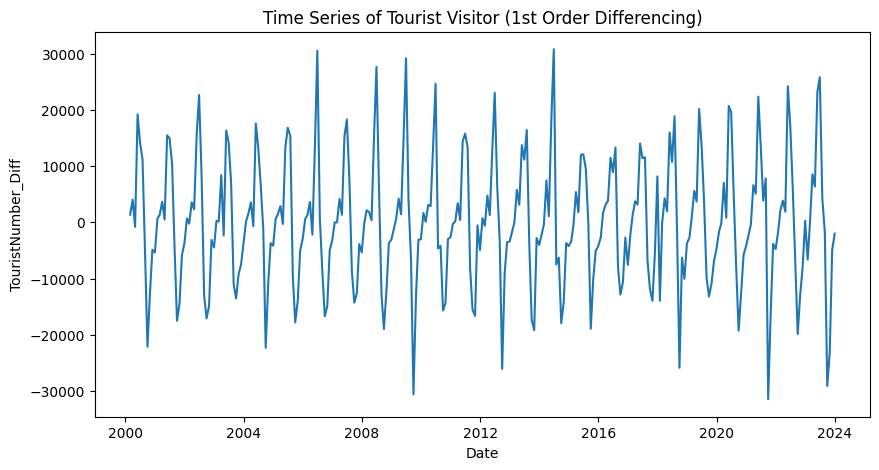

In [36]:
# Plot hasil differencing TouristNumber untuk melihat stasioneritas
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Date', y='TouristNumber_Diff')
plt.title('Time Series of Tourist Visitor (1st Order Differencing)')
plt.show()

## Plot ACF & PACF

In [37]:
# drop nilai missing pada data original setelah diffencing
diff_data = df['TouristNumber_Diff'].dropna()

print(f'Jumlah data missing: {diff_data.isna().sum()}')

Jumlah data missing: 0


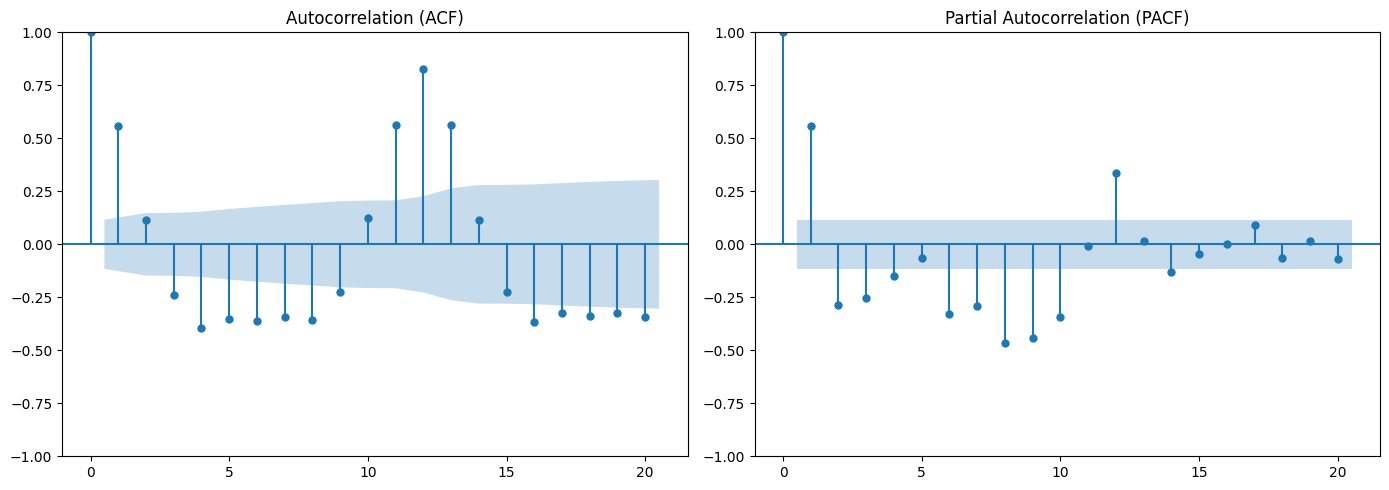

In [28]:
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plot_acf(diff_data, ax=plt.gca(), lags=20)
plt.title("Autocorrelation (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(diff_data, ax=plt.gca(), lags=20)
plt.title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()